## 判断拍摄的照片和身份证上照片是否为同一个人识别

通过身份证上照片的人脸的128个特征点，和摄像头拍摄的照片上人脸的128个特征点进行对比，通过夹角余弦距离判断两者之间是否是同一个人。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import dlib
import matplotlib.patches as mpatches
from skimage import io,draw,transform,color
import numpy as np
import pandas as pd
from scipy.spatial import distance

**首先定义通过dlib库进行识别人脸，找到特征点，生成特征的方式**

In [2]:
## 使用dlib.get_frontal_face_detector识别人脸
detector = dlib.get_frontal_face_detector()
## 定义找到人脸特征点的方法
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
## 定义提前训练好的人脸分类器,用于提取人脸的128个特征
facerec = dlib.face_recognition_model_v1("dlib_face_recognition_resnet_model_v1.dat")

**找到身份证图像的人脸、特征点和128个特征数据**

(128,)


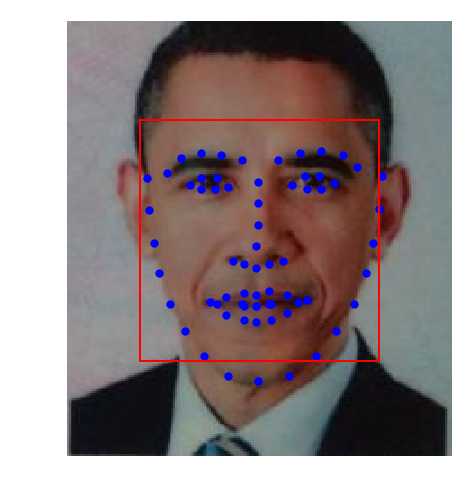

In [3]:
## 读取生成身份证图像数据
IDimage = io.imread("IDimages/aobamaIDcard.jpg")
## 生成身份证图像的特征
dets = detector(IDimage, 2)
## 将识别的图像可视化
plt.figure()
ax = plt.subplot(111)
ax.imshow(IDimage)
plt.axis("off")
## 人脸框
left = dets[0].left()
top = dets[0].top()
right = dets[0].right()
bottom = dets[0].bottom()
rect = mpatches.Rectangle((left,bottom), right - left, top - bottom,
                              fill=False, edgecolor='red', linewidth=1)
ax.add_patch(rect)
## 从检测到的人脸中识别特征点
shape = predictor(IDimage, dets[0])
detected_landmarks = shape.parts()  
landmarks = np.array([[p.x, p.y] for p in detected_landmarks])
ax.scatter(landmarks[:,0],landmarks[:,1],c="b",s = 10)
## 生成用于分类的128个特征
cla = facerec.compute_face_descriptor(IDimage,shape)
IDfeature = np.array(cla)
print(IDfeature.shape)
plt.show()

可以发现通过上面的方法能够很好的找到特征，人脸等信息。

**下面使用5张图像作为测试图像，其中前3张和身份证为同一个人，后2张是不同的人，分析图像特征之间夹角余弦距离，方便确定判断阈值。**

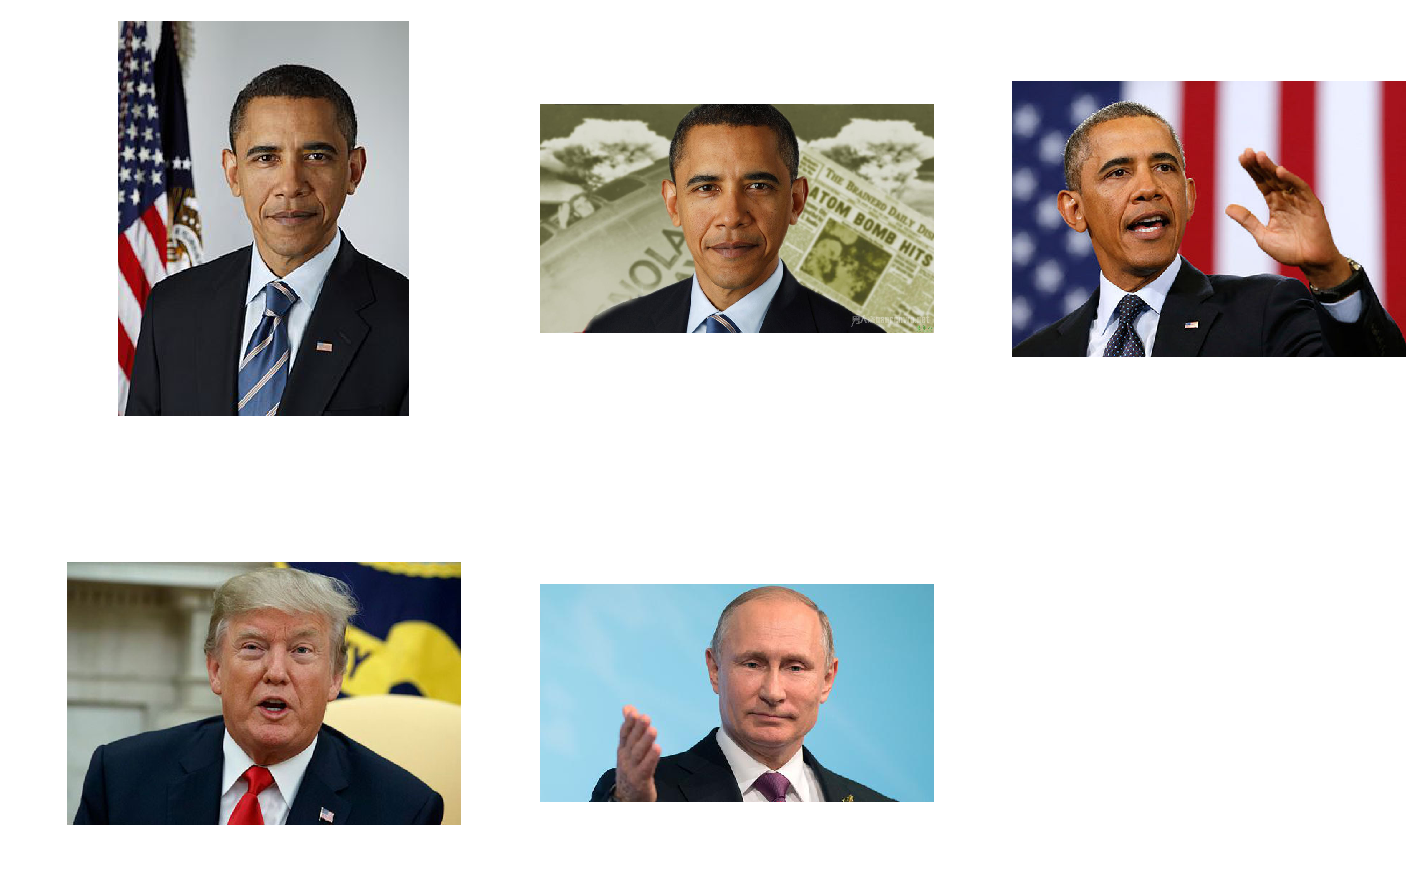

In [4]:
## 读取相互对比的图像
imob1 = io.imread("Obama对比1.jpg")
imob2 = io.imread("Obama对比2.jpg")
imob3 = io.imread("Obama对比3.jpg")
imtrup = io.imread("trump对比1.jpg")
impujing = io.imread("普京对比1.jpg")
## 将对比图像可视化
image_test = [imob1,imob2,imob3,imtrup,impujing]
plt.figure(figsize=(12,8))
for ii,im in enumerate(image_test):
    plt.subplot(2,3,ii+1)
    plt.imshow(im)
    plt.axis("off")


**接下来找到5张测试图像中的人脸、特征点和用来比较相似性的128个特征。**

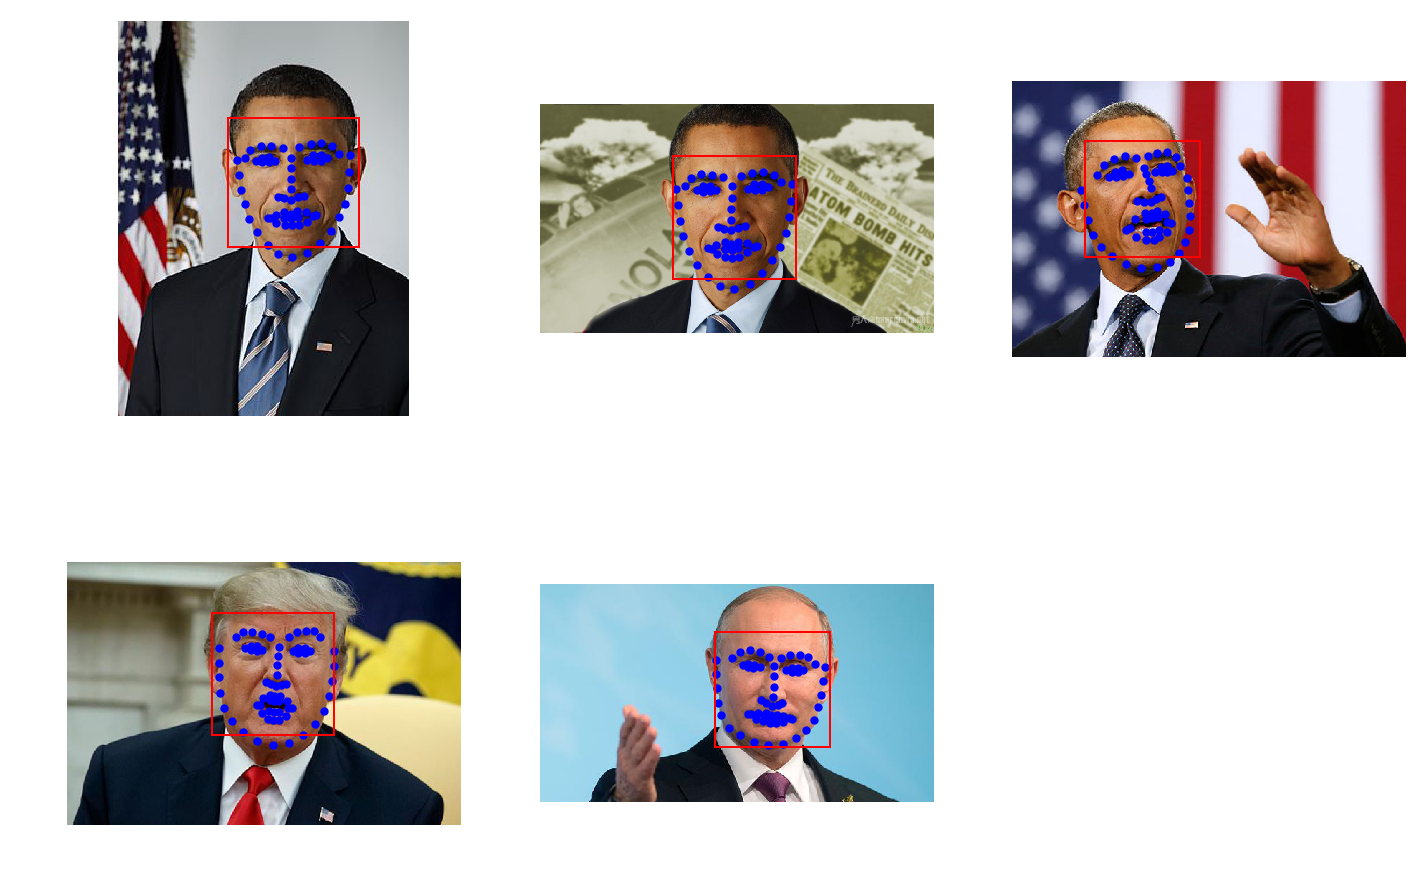

In [5]:
## 得到用来测试的每个人脸128个用于判断
clfeature = []
plt.figure(figsize=(12,8))
for ii,im in enumerate(image_test):
    ## 检测人脸
    dets = detector(im, 2)
    ## 将识别的图像可视化
    ax = plt.subplot(2,3,ii+1)
    ax.imshow(im)
    plt.axis("off")
    for i, face in enumerate(dets):
        # 在图片中标注人脸，并显示
        left = face.left()
        top = face.top()
        right = face.right()
        bottom = face.bottom()
        rect = mpatches.Rectangle((left,bottom), right - left, top - bottom,
                                      fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        ## 从检测到的人脸中识别特征点
        shape = predictor(im, face)
        detected_landmarks = shape.parts()  
        landmarks = np.array([[p.x, p.y] for p in detected_landmarks])
        ax.scatter(landmarks[:,0],landmarks[:,1],c="b",s = 10)
        ## 生成用于分类的128个特征
        cla = facerec.compute_face_descriptor(im,shape)
        clfeature.append(np.array(cla))
plt.show()

**特征全部找到后，计算5张图像和省份证图像人脸特征之间的夹角余弦距离，用来确定可靠的判别阈值。**

两者之间的距离是: 0.01867090972453489
两者之间的距离是: 0.015447268871595865
两者之间的距离是: 0.05160464437471446
两者之间的距离是: 0.17330716884377795
两者之间的距离是: 0.18805681059558077


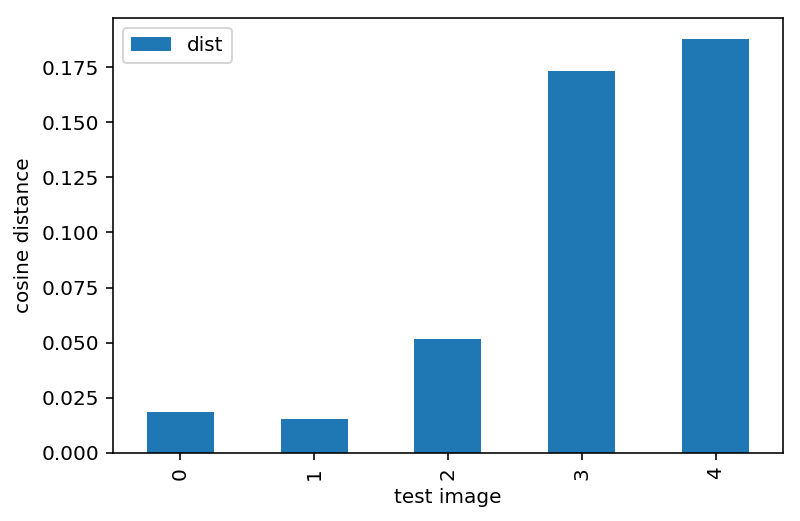

In [6]:
## 计算人脸特征之间的距离
dist = []
for f in clfeature:
    d = distance.cosine(IDfeature,f)
    print("两者之间的距离是:",d)
    dist.append(d)

## 将人脸特征之间的距离用直方图显示
pd.DataFrame({"dist":dist}).plot(kind = "bar")
plt.xlabel("test image")
plt.ylabel("cosine distance")
plt.show()

**通过观察可以将阈值定义为0.03～0.1之间，如果对安全性要求很高，可以定义小一些，如果要求不高，可以定义大一些。这里先定义为0.08。**

In [7]:
## 定义一个判断摄像拍摄图片是否和身份证照片一致
def IDcardImrec(IDcardim,testim,threshold = 0.08):
    """
    IDcardim:从身份证上提取的照片
    testim:摄像头拍摄照片或者图片
    threshold:判断是否未同一张图像的阈值
    """
    import dlib
    import numpy as np
    from scipy.spatial import distance
    ## 识别人脸的方法
    detector = dlib.get_frontal_face_detector()
    ## 找到人脸特征点的方法
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    ## 定义提前训练好的人脸分类器,用于提取人脸的128个特征
    facerec = dlib.face_recognition_model_v1("dlib_face_recognition_resnet_model_v1.dat")
    ## ============================
    ## 找到IDcardim的人脸图像特征
    dets = detector(IDcardim, 2)
    ## 从检测到的人脸中识别特征点
    shape = predictor(IDcardim, dets[0])
    ## 生成用于分类的128个特征
    cla = facerec.compute_face_descriptor(IDcardim,shape)
    IDfeature = np.array(cla)
    ## ============================
    ## 找到testim的人脸图像特征
    dets = detector(testim, 2)
    ## 从检测到的人脸中识别特征点
    shape = predictor(testim, dets[0])
    ## 生成用于分类的128个特征
    cla = facerec.compute_face_descriptor(testim,shape)
    test_feature = np.array(cla)
    ## ============================
    ## 计算两者之间的夹角余弦距离
    dist = distance.cosine(IDfeature,test_feature)
    if dist > threshold:
        print("验证失败")
        ret = 0
    else:
        print("验证成功")
        ret = 1
        
    return ret

In [8]:
## 对上方函数进行测试
for im in image_test:
    IDcardImrec(IDimage,im,threshold = 0.08)

验证成功
验证成功
验证成功
验证失败
验证失败
